In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from progressbar import progressbar as pbar
from scipy.optimize import minimize

%matplotlib inline

In [2]:
def plot_kdehist(x, kde_bw=None, kde_label=None, kde_color="black", kde_lw=2, kde_alpha=1, **kwargs):
    if len(x)==0:
        return
    s = np.max([np.std(x),.01])
    l = np.max([1, len(x)])
    bw = 1.06*s*l**-.2 if kde_bw is None else kde_bw
    kd = KernelDensity(bandwidth=bw)
    kd.fit(x.reshape(-1,1))
    rx = np.linspace(np.min(x),np.max(x),100)
    sx = np.exp(kd.score_samples(rx.reshape(-1,1)))
    plt.plot(rx,sx, color=kde_color, alpha=kde_alpha, lw=kde_lw, label=kde_label)
    plt.hist(x, density=True, **kwargs)

    
def figure(figsize, gridsize):
    plt.figure(figsize=figsize)
    for i in range(gridsize[0]*gridsize[1]):
        yield i,plt.subplot(*gridsize, i+1)
        
def sigm(x):
    if type(x)==int or type(x)==float and x>100:
        x = 100
    else:
        x[x>100]=100
        
    return 1/(1+np.exp(-x))

In [3]:
np.exp(-100)

3.720075976020836e-44

In [4]:
from sklearn.datasets import make_moons, make_circles

In [5]:
X, y = make_moons(200, noise=.3)
#X, y = make_circles(400, noise=.1)

In [6]:
from mlutils import plots
from importlib import reload
reload(plots)

<module 'mlutils.plots' from '/home/user/share/Dropbox/teaching/machine-learning/2019.ref/mlutils/plots.py'>

(-1.8360529866679276,
 2.547857039858607,
 -1.0693660198434494,
 1.8504895125429377)

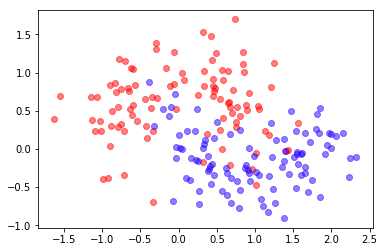

In [7]:
plots.plot_2Ddata(X,y)
plt.axis("equal")

## change the cost function in this NN so that it maximizes the MLE


$$\underset{W,b}{\text{arg max}} \;\; \sum P(W,b|X,y) - \lambda ||W,b||^2$$


where

- $P(W,b|X,y=0)$ is given by the output of the first neuron after the softmax output
- $P(W,b|X,y=1)$ is given by the output of the second neuron after the softmax output
- $\lambda$ is the regularization parameter


In [36]:
class NN:
    def __init__(self, reg=0):
        self.colors = ["red", "blue", "green", "yellow", "black", "orange", "brown"]

        self.W = []
        self.b = []
        self.activ_funcs = []
        self.activations = []
        self.outputs     = []
        self.reg=0
        
    def add_layer(self, Wshape, activ_func=None):
        assert len(Wshape)==2, "layer shape must represent 2D array"
        assert len(self.W)==0 or self.W[-1].shape[1]==Wshape[0], "non matching layer shapes"
        
        if activ_func is None:
            activ_func = lambda x: 1/(1+np.exp(-x)) # sigmoid
                    
        self.W.append(np.zeros(Wshape))
        self.b.append(np.zeros(Wshape[1]))
        self.activations.append(np.zeros(Wshape[1]))
        self.outputs.append(np.zeros(Wshape[1]))
        self.activ_funcs.append(activ_func)
        return self
    
    def fw(self, X):
        for i in range(len(self.W)):
            self.activations[i] = X.dot(self.W[i])+self.b[i]
            self.outputs[i] = self.activ_funcs[i](self.activations[i])
            X = self.outputs[i]
            
        # output softmax
        self.outputs[i] = np.exp(X)/np.sum(np.exp(X), axis=1).reshape(-1,1)
        return self.outputs[i]
    
    def fit(self, X, y, reg=None):
        reg = reg or self.reg
        
        cost = lambda t: self.unflatten(t).loss(X,y) + reg*np.sum(t**2)
        ###
        # replace the cost here with the likelihood
        # watch out!! you want to MAXIMIZE the log likelihood
        
        r = minimize(cost, self.random_init().flatten())
        nn.unflatten(r.x)
        return self
    
    def predict(self, X):
        return self.fw(X).argmax(axis=1)

    def score(self, X, y):
        return np.mean(self.predict(X)==y)
    
    def likelihood(self, X, y):
        return # IMPLEMENT YOUR LOG LIKELIHOOD
    
    def loss(self, X, y):
        return np.mean(nn.fw(X)[:,1]**(1-y)*nn.fw(X)[:,0]**y)
            
    def mean_accuracy(self, X, y):
        return np.mean(nn.fw(X).argmax(axis=1)==y)
    
    def random_init(self, initializer=None):
        if initializer is None:
            initializer = lambda layer, size: np.random.normal(size=size)
        
        self.W = [initializer(l, w.shape) for l,w in enumerate(self.W)]
        self.b = [initializer(l, b.shape) for l,b in enumerate(self.b)]
        return self

    def plot_activations(self, X, layer, y=None):
        n = self.W[layer].shape[1]
        for i,ax in figure(figsize=(n*3,2), gridsize=(1,n)):
            if y is None:
                self.fw(X)
                plot_kdehist(self.activations[layer][:,i], bins=30, alpha=.5)    
            else:
                for cn,c in enumerate(np.unique(y)):
                    self.fw(X[y==c])
                    plot_kdehist(self.activations[layer][:,i], bins=30, alpha=.5, 
                                 color=self.colors[cn], kde_color=self.colors[cn])    
                    
            
    def plot_outputs(self, X, layer, y=None):
        n = self.W[layer].shape[1]
        for i,ax in figure(figsize=(n*3,2), gridsize=(1,n)):
            if y is None:
                self.fw(X)
                plot_kdehist(self.outputs[layer][:,i], bins=30, alpha=.5)    
            else:
                for cn,c in enumerate(np.unique(y)):
                    self.fw(X[y==c])                
                    plot_kdehist(self.outputs[layer][:,i], bins=30, alpha=.5, 
                                 color=self.colors[cn], kde_color=self.colors[cn])    
                
    
    def __repr__(self):
        return "layer shapes: " + ", ".join([str(i.shape) for i in self.W])
    
    
    def flatten(self):
        wf = [list(w.flatten()) for w in self.W]
        wf = [j for i in wf for j in i]

        bf = [list(b.flatten()) for b in self.b]
        bf = [j for i in bf for j in i]

        return np.r_[wf+bf]

    def unflatten(self, f):
        i,k=0,0
        for i in range(len(self.W)):
            l = self.W[i].shape[0]*self.W[i].shape[1]
            self.W[i] = f[k:k+l].reshape(self.W[i].shape)
            k += l

        for i in range(len(self.b)):
            l = self.b[i].shape[0]
            self.b[i] = f[k:k+l].reshape(self.b[i].shape)
            k += l
        
        return self
    
    def checksum(self):
        return np.sum([i.sum() for i in self.W])+np.sum([i.sum() for i in self.W])
    
    def __eq__(self, other):
        if len(self.W)!=len(other.W) or len(self.b)!=len(other.b):
            return False
        
        return np.alltrue([np.allclose(self.W[i], other.W[i]) for i in range(len(self.W))] + \
                          [np.allclose(self.b[i], other.b[i]) for i in range(len(self.b))] )
        
    def copy(self):
        r = self.__class__()
        r.W = [i for i in self.W]
        r.b = [i for i in self.b]
        r.activ_funcs = [i for i in self.activ_funcs]
        r.activations = [np.zeros(i.shape[1]) for i in self.W]
        r.outputs = [np.zeros(i.shape[1]) for i in self.W]
        return r

In [37]:
nn = NN()
nn.add_layer((2,8)).add_layer((8,2))
nn.random_init(initializer = lambda layer, size: np.random.normal(size=size)*3)
nn.checksum()

-26.82705215437199

In [44]:
nn.fit(X,y, reg=0)
print (nn.score(X,y))

0.865


In [45]:
import itertools
import seaborn as sns

In [46]:
sx = np.linspace(np.min(X[:,1])-.2, np.max(X[:,1])+.2, 100)
sy = np.linspace(np.min(X[:,0])-.25, np.max(X[:,0])+.25, 100)

r0 = np.zeros((len(sx), len(sy)))
r1 = np.zeros((len(sx), len(sy)))

for ix, iy in itertools.product(range(len(sx)), range(len(sy))):
    k = nn.fw(np.r_[[[sy[iy], sx[ix]]]])
    r0[ix, iy] = k[0][0]
    r1[ix, iy] = k[0][1]    

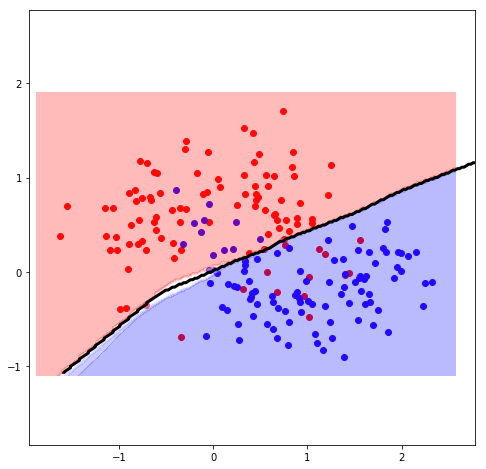

In [47]:
plt.figure(figsize=(8,8))
plots.plot_2Ddata_with_boundary(nn.predict, X, y,dots_alpha=1, line_alpha=1, line_width=3)
plt.contourf(sy,sx,r0, alpha=0.3, cmap=plt.cm.bwr)
plt.axis("equal");

## layer 1 activations before and after sigmoid

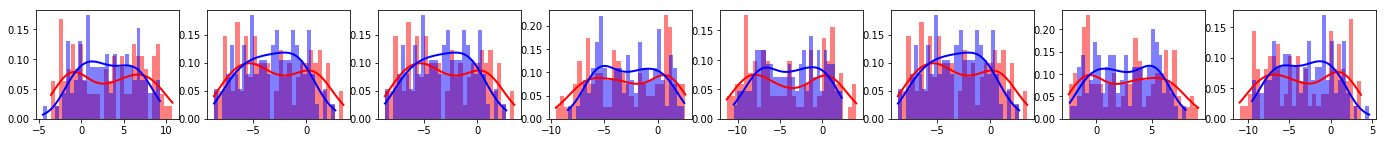

In [627]:
nn.plot_activations(X,y=y, layer=0)

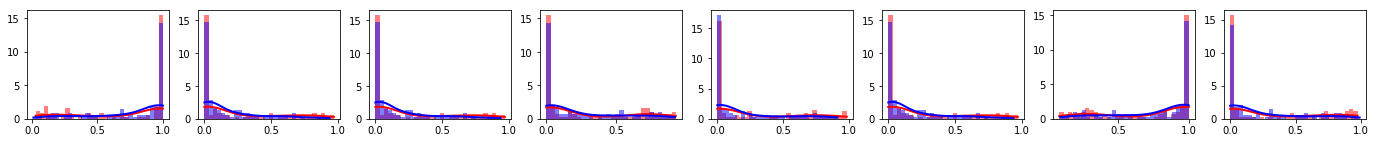

In [628]:
nn.plot_outputs(X, y=y,layer=0)

## layer 2 activations before and after sigmoid

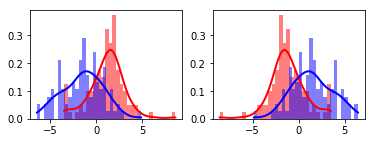

In [629]:
nn.plot_activations(X, y=y, layer=1)

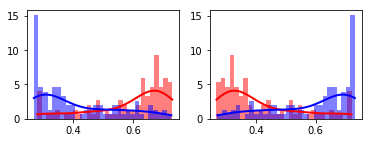

In [630]:
nn.plot_outputs(X, y=y, layer=1)